### SNOWPARK MASTERCLASS
#### Session: Data Preprocessing and Advanced Transformations in Snowflake for AI/ML

We will
- 1. Access and analyze Insurance Claims data using Dataframe API
- 2. Calculate a new column using Dataframe API and vectorized UDF
- 3. Walk through a few transformations that are included in the Snowpark ML Preprocessing API
- 4. Build a preprocessing pipeline using Snowpark ML Modeling API
- 5. Train an XGBoost model with the Insurance claims dataset using the Snowpark ML Model API
- 6. Use Snowpark ML's Distributed GridSearchCV() function to find optimal model parameters

***Note: All feature transformations using Snowpark ML & hyperparameter tuning are distributed operations in the same way that Snowpark DataFrame operations are.***

### Import Libraries

In [321]:
# Import the necessary libraries
# Data Science Libs
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


#from src.util.local import get_env_var_config
# Snowpark for Python
from snowflake.snowpark.session import Session
from snowflake.snowpark.version import VERSION
from snowflake.snowpark.dataframe import col, DataFrame
from snowflake.snowpark.functions import udf, sum, lit, log, when,   upper,regexp_replace,min, max, round
from snowflake.snowpark.types import IntegerType, StringType, StructType, FloatType, StructField, DateType, Variant, VariantType, PandasSeriesType


from snowflake.snowpark.types import DecimalType, StructType, StructField, DoubleType, StringType
from snowflake.snowpark import Window as window

# Snowpark ML
import snowflake.ml.modeling.preprocessing as snowml
from snowflake.ml.modeling.pipeline import Pipeline
from snowflake.ml.modeling.metrics.correlation import correlation

#from snowflake.ml.feature_store.feature_store import FeatureStore, CreationMode, FeatureView, Entity

from snowflake.ml.modeling.xgboost import XGBRegressor
from snowflake.ml.modeling.model_selection import GridSearchCV
from snowflake.ml.registry import model_registry
from snowflake.ml._internal.utils import identifier

from snowflake.ml.modeling.metrics import mean_absolute_percentage_error

# warning suppresion
import warnings; warnings.simplefilter('ignore')

# Misc
import sys
from os import environ
import json
import nbformat
import joblib
import cachetools


### Establish Secure Connection to Snowflake

*Other connection options include Username/Password, MFA, OAuth, Okta, SSO. For more information, refer to the [Python Connector](https://docs.snowflake.com/en/developer-guide/python-connector/python-connector-example) documentation.*

In [322]:
# Edit the data_scientist_auth.json before creating the session object below
# Create Snowflake Session object
with open("data_scientist_auth.json") as f:
    connection_parameters = json.load(f)
session = Session.builder.configs(connection_parameters).create()
session.sql_simplifier_enabled = True

snowflake_environment = session.sql('SELECT current_user(), current_version()').collect()
snowpark_version = VERSION

# Current Environment Details
print('\nConnection Established with the following parameters:')
print('User                        : {}'.format(snowflake_environment[0][0]))
print('Role                        : {}'.format(session.get_current_role()))
print('Database                    : {}'.format(session.get_current_database()))
print('Schema                      : {}'.format(session.get_current_schema()))
print('Warehouse                   : {}'.format(session.get_current_warehouse()))
print('Snowflake version           : {}'.format(snowflake_environment[0][1]))
print('Snowpark for Python version : {}.{}.{}'.format(snowpark_version[0],snowpark_version[1],snowpark_version[2]))



Connection Established with the following parameters:
User                        : SVADAKATH
Role                        : "ACCOUNTADMIN"
Database                    : "TESTING_STUFF"
Schema                      : "MASTERCLASS_FEAT_ENG"
Warehouse                   : "DEMO_WH"
Snowflake version           : 8.1.0
Snowpark for Python version : 1.10.0


### Access Data 

In [323]:
# Specify the table name where we stored the Insurance claims dataset
DEMO_TABLE = 'masterclass_motor_insurance_policy_claims'
input_tbl = f"{session.get_current_database()}.{session.get_current_schema()}.{DEMO_TABLE}"

insurance_policy_claims_df = session.table(input_tbl)

# Display the DataFrame

insurance_policy_claims_df.show(5)

------------------------------------------------------------------------------------------------------------------------------------------------
|"IDPOL"  |"CLAIMNB"  |"EXPOSURE"  |"AREA"  |"VEHPOWER"  |"VEHAGE"  |"DRIVAGE"  |"BONUSMALUS"  |"VEHBRAND"  |"VEHGAS"   |"DENSITY"  |"REGION"  |
------------------------------------------------------------------------------------------------------------------------------------------------
|1        |1          |0.1         |'D'     |V5          |0         |55         |50            |'B12'       |'Regular'  |1217       |'R82'     |
|3        |1          |0.77        |'D'     |V5          |0         |55         |50            |'B12'       |'Regular'  |1217       |'R82'     |
|5        |1          |0.75        |'B'     |V6          |2         |52         |50            |'B12'       |'Diesel'   |54         |'R22'     |
|10       |1          |0.09        |'B'     |V7          |0         |46         |50            |'B12'       |'Diesel'   |76       

## Compare DataFrame Size
Let's bring a sample of our Snowflake dataset to our Python environment in a pandas DataFrame using the to_pandas() function. We will compare how much memory is used for the pandas DataFrame compared to the Snowpark DataFrame. As we will see, no memory is used for the Snowpark DataFrame in our Python environment. All data in the Snowpark DataFrame remains on Snowflake.<br>

**Value:** No copies or movement of data when working with Snowpark DataFrames.

In [324]:
insurance_policy_claims_pd_df=insurance_policy_claims_df.to_pandas()

# Get Snowpark DataFrame size
snowpark_df_size = sys.getsizeof(insurance_policy_claims_df) / (1024*1024)
print(f"Snowpark DataFrame Size (insurance_policy_claims_df): {snowpark_df_size:.2f} MB")

# Get pandas DataFrame size
pandas_df_size = sys.getsizeof(insurance_policy_claims_pd_df) / (1024*1024)
print(f"Pandas DataFrame Size (insurance_policy_claims_pd_df): {pandas_df_size:.2f} MB")

Snowpark DataFrame Size (insurance_policy_claims_df): 0.00 MB
Pandas DataFrame Size (insurance_policy_claims_pd_df): 250.05 MB


In [97]:
# Scale Exposure using StandardScaler

input_columns_std_scaler=["EXPOSURE"]
output_columns_std_scaler = ["EXPOSURE_SCALED"]

snowml_stdscale = snowml.StandardScaler(input_cols=input_columns_std_scaler, output_cols=output_columns_std_scaler, with_mean='True')

stdscaler_transformed_claims_frequency_df = snowml_stdscale.fit(insurance_policy_claims_df).transform(insurance_policy_claims_df)

#np.array(transformed_claims_df.columns)




In [ ]:
# Create input columns for reverse engineering Exposure
stdscaler_transformed_claims_frequency_df=stdscaler_transformed_claims_frequency_df \
    .join(stdscaler_transformed_claims_frequency_df.groupBy().agg(min(col("EXPOSURE")).alias("Min_Original_Value")))\
    .join(stdscaler_transformed_claims_frequency_df.groupBy().agg(max(col("EXPOSURE")).alias("Max_Original_Value")))\
    .join(stdscaler_transformed_claims_frequency_df.groupBy().agg(min(col("EXPOSURE_SCALED")).alias("Min_Scaled_Value")))\
    .join(stdscaler_transformed_claims_frequency_df.groupBy().agg(max(col("EXPOSURE_SCALED")).alias("Max_Scaled_Value")))\
    .rename({col("EXPOSURE"):"ORIGINAL_EXPOSURE"})


stdscaler_transformed_claims_frequency_df.show()
stdscaler_transformed_claims_frequency_df.write.mode("overwrite").save_as_table("TESTING_STUFF.MASTERCLASS_FEAT_ENG.masterclass_claims_wo_exposure")

### Calculation

*Reverse engineer the original `EXPOSURE` values based on a formula using scaled and min/max values


In [326]:
input_tbl_wo_exposure = f"{session.get_current_database()}.{session.get_current_schema()}.{'masterclass_claims_wo_exposure'}"

insurance_policy_claims_wo_exposure_df = session.table(input_tbl_wo_exposure)

# Display the DataFrame

insurance_policy_claims_wo_exposure_df.show(5)

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"EXPOSURE_SCALED"    |"IDPOL"  |"CLAIMNB"  |"ORIGINAL_EXPOSURE"  |"AREA"  |"VEHPOWER"  |"VEHAGE"  |"DRIVAGE"  |"BONUSMALUS"  |"VEHBRAND"  |"VEHGAS"   |"DENSITY"  |"REGION"  |"MIN_ORIGINAL_VALUE"  |"MAX_ORIGINAL_VALUE"  |"MIN_SCALED_VALUE"   |"MAX_SCALED_VALUE"  |
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|-1.1764586839194764  |1        |1          |0.1                  |'D'     |V5          |0         |55         |50            |'B12'       |'Regular'  |1217       |'R82'     |0.002732240437        |2.01   

<img src="./ExposureRE.png" alt="Alt text" width="400"/>


In [327]:
# Calculate Exposure using proxy input values
insurance_policy_claims_wo_exposure_df=insurance_policy_claims_wo_exposure_df.with_column("Calculated Exposure", \
    round((insurance_policy_claims_wo_exposure_df["EXPOSURE_SCALED"] - insurance_policy_claims_wo_exposure_df["Min_Scaled_Value"])*\
    ((insurance_policy_claims_wo_exposure_df["Max_Original_Value"] - insurance_policy_claims_wo_exposure_df["Min_Original_Value"])/\
    (insurance_policy_claims_wo_exposure_df["Max_Scaled_Value"]- insurance_policy_claims_wo_exposure_df["Min_Scaled_Value"] )\
    )\
    + (insurance_policy_claims_wo_exposure_df["Min_Original_Value"])\
    ,2))\
    .drop("IDPOL","CLAIMNB","VEHBRAND","AREA","VEHPOWER","VEHGAS","VEHAGE","DENSITY","REGION","BONUSMALUS","DRIVAGE")
insurance_policy_claims_wo_exposure_df.show()
          

----------------------------------------------------------------------------------------------------------------------------------------------------------------
|"EXPOSURE_SCALED"      |"ORIGINAL_EXPOSURE"  |"MIN_ORIGINAL_VALUE"  |"MAX_ORIGINAL_VALUE"  |"MIN_SCALED_VALUE"   |"MAX_SCALED_VALUE"  |"Calculated Exposure"  |
----------------------------------------------------------------------------------------------------------------------------------------------------------------
|-1.1764586839194764    |0.1                  |0.002732240437        |2.01                  |-1.4433542458411501  |4.06444051598674    |0.1                    |
|0.6619719254717098     |0.77                 |0.002732240437        |2.01                  |-1.4433542458411501  |4.06444051598674    |0.77                   |
|0.6070933998182415     |0.75                 |0.002732240437        |2.01                  |-1.4433542458411501  |4.06444051598674    |0.75                   |
|-1.2038979467462105    |0.09     

In [328]:
#See underlying SQL
insurance_policy_claims_wo_exposure_df.explain()

---------DATAFRAME EXECUTION PLAN----------
Query List:
1.
SELECT "EXPOSURE_SCALED", "ORIGINAL_EXPOSURE", "MIN_ORIGINAL_VALUE", "MAX_ORIGINAL_VALUE", "MIN_SCALED_VALUE", "MAX_SCALED_VALUE", round(((("EXPOSURE_SCALED" - "MIN_SCALED_VALUE") * (("MAX_ORIGINAL_VALUE" - "MIN_ORIGINAL_VALUE") / ("MAX_SCALED_VALUE" - "MIN_SCALED_VALUE"))) + "MIN_ORIGINAL_VALUE"), 2) AS "Calculated Exposure" FROM "TESTING_STUFF"."MASTERCLASS_FEAT_ENG".masterclass_claims_wo_exposure
Logical Execution Plan:
GlobalStats:
    partitionsTotal=1
    partitionsAssigned=1
    bytesAssigned=7423488
Operations:
1:0     ->Result  MASTERCLASS_CLAIMS_WO_EXPOSURE.EXPOSURE_SCALED, MASTERCLASS_CLAIMS_WO_EXPOSURE.ORIGINAL_EXPOSURE, 0.002732240437, 2.01, -1.4433542458411501, 4.06444051598674, ROUND(((MASTERCLASS_CLAIMS_WO_EXPOSURE.EXPOSURE_SCALED - -1.4433542458411501) * (2.0072677595629997 / 5.50779476182789)) + 0.002732240437, 2.0)  
1:1          ->TableScan  TESTING_STUFF.MASTERCLASS_FEAT_ENG.MASTERCLASS_CLAIMS_WO_EXPOSURE  

In [329]:
#save data to a table
insurance_policy_claims_wo_exposure_df.write.mode("overwrite").save_as_table("TESTING_STUFF.MASTERCLASS_FEAT_ENG.masterclass_claims_wo_exposure2")


In [224]:
# This is a vectorized UDF that scores rows in batches which is much more efficient than row-by-row scoring


@udf(name="CALCULATE_EXPOSURE", 
    stage_location='@MASTERCLASS_ML_ASSETS', 
    packages=['pandas'],
    max_batch_size= 50,
    input_types=[FloatType(),FloatType(),FloatType(),FloatType(),FloatType()],
    return_type=FloatType(),
    is_permanent=True, 
    replace=True,
    session=session)
def calculate_exposure(pd_df: pd.DataFrame) -> pd.Series:
    import os
    import sys
    import pandas

    return pd.Series((pd_df[0]-pd_df[3])*((pd_df[2]-pd_df[1])/(pd_df[4]-pd_df[3]))+(pd_df[1])
                     )

In [330]:
insurance_policy_claims_wo_exposure_df.with_column("Calculated Exposure Vectorized UDF", \
    round(calculate_exposure("EXPOSURE_SCALED","MIN_ORIGINAL_VALUE","MAX_ORIGINAL_VALUE"\
    ,"MIN_SCALED_VALUE","MAX_SCALED_VALUE"	\
    ),2)).show()


-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"EXPOSURE_SCALED"      |"ORIGINAL_EXPOSURE"  |"MIN_ORIGINAL_VALUE"  |"MAX_ORIGINAL_VALUE"  |"MIN_SCALED_VALUE"   |"MAX_SCALED_VALUE"  |"Calculated Exposure"  |"Calculated Exposure Vectorized UDF"  |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|-1.1764586839194764    |0.1                  |0.002732240437        |2.01                  |-1.4433542458411501  |4.06444051598674    |0.1                    |0.1                                   |
|0.6619719254717098     |0.77                 |0.002732240437        |2.01                  |-1.4433542458411501  |4.06444051598674    |0.77                   |0.77                                  |


In [331]:
#Continue with original claims dataset
insurance_policy_claims_df.show()

------------------------------------------------------------------------------------------------------------------------------------------------
|"IDPOL"  |"CLAIMNB"  |"EXPOSURE"  |"AREA"  |"VEHPOWER"  |"VEHAGE"  |"DRIVAGE"  |"BONUSMALUS"  |"VEHBRAND"  |"VEHGAS"   |"DENSITY"  |"REGION"  |
------------------------------------------------------------------------------------------------------------------------------------------------
|1        |1          |0.1         |'D'     |V5          |0         |55         |50            |'B12'       |'Regular'  |1217       |'R82'     |
|3        |1          |0.77        |'D'     |V5          |0         |55         |50            |'B12'       |'Regular'  |1217       |'R82'     |
|5        |1          |0.75        |'B'     |V6          |2         |52         |50            |'B12'       |'Diesel'   |54         |'R22'     |
|10       |1          |0.09        |'B'     |V7          |0         |46         |50            |'B12'       |'Diesel'   |76       

In [332]:
#data of various types — a mix of numeric and categorical
list(insurance_policy_claims_df.schema)


[StructField('IDPOL', StringType(16777216), nullable=True),
 StructField('CLAIMNB', LongType(), nullable=True),
 StructField('EXPOSURE', DoubleType(), nullable=True),
 StructField('AREA', StringType(16777216), nullable=True),
 StructField('VEHPOWER', StringType(16777216), nullable=True),
 StructField('VEHAGE', LongType(), nullable=True),
 StructField('DRIVAGE', LongType(), nullable=True),
 StructField('BONUSMALUS', LongType(), nullable=True),
 StructField('VEHBRAND', StringType(16777216), nullable=True),
 StructField('VEHGAS', StringType(16777216), nullable=True),
 StructField('DENSITY', LongType(), nullable=True),
 StructField('REGION', StringType(16777216), nullable=True)]

### Exploratory data analysis (EDA)

In [333]:
#EDA1 using AREA
#calculate 
#1.proportion of total exposure in each category of area
#2.claims frequency — the number of claims per unit exposure — viewed in aggregate.


area_exposure_df=insurance_policy_claims_df.groupBy("Area").agg(sum("ClaimNB").alias("Area_Claims"),\
    sum("Exposure").alias("Area_Exposure")) \
    .join(insurance_policy_claims_df.groupBy().agg(sum("EXPOSURE").alias("Total_Exposure"))) 

area_exposure_df  =area_exposure_df.with_columns(["Percentage_of_total_exposure", "claims_per_unit_exposure"], [(area_exposure_df["AREA_EXPOSURE"] / area_exposure_df["Total_Exposure"])\
                                                 ,  (area_exposure_df["AREA_CLAIMS"]/ area_exposure_df["Area_Exposure"] )]).sort(area_exposure_df.Area)
area_exposure_df.show()



----------------------------------------------------------------------------------------------------------------------------------
|"AREA"  |"AREA_CLAIMS"  |"AREA_EXPOSURE"     |"TOTAL_EXPOSURE"    |"PERCENTAGE_OF_TOTAL_EXPOSURE"  |"CLAIMS_PER_UNIT_EXPOSURE"  |
----------------------------------------------------------------------------------------------------------------------------------
|'A'     |5063           |61969.37771240342   |358499.44546298234  |0.17285766685740162             |0.08170164340679865         |
|'B'     |3800           |43012.32393068327   |358499.44546298234  |0.11997877395635917             |0.08834677256973861         |
|'C'     |9875           |104449.00378471403  |358499.44546298234  |0.2913505309605818              |0.09454374519793354         |
|'D'     |8428           |77120.19169174308   |358499.44546298234  |0.21511941696910183             |0.10928396072571418         |
|'E'     |7805           |63819.31426978038   |358499.44546298234  |0.1780178883885

In [334]:
#%%timeit

window_spec1 = window().partition_by("Area")
window_spec2 = window().partition_by()
window_test_df=insurance_policy_claims_df.groupBy("Area").agg(sum("ClaimNB").alias("Area_Claims"),\
    sum("Exposure").alias("Area_Exposure"),
    (sum("Area_Exposure").over(window_spec1) / sum("Area_Exposure").over(window_spec2)).as_("PERCENTAGE_OF_TOTAL_EXPOSURE"),
    (sum("ClaimNB")/ sum("Exposure")).alias("claims_per_unit_exposure")
    ).sort(area_exposure_df.Area) 
window_test_df.show()


#EDA1 with Window
#Run with magic command (Optional)

-------------------------------------------------------------------------------------------------------------
|"AREA"  |"AREA_CLAIMS"  |"AREA_EXPOSURE"     |"PERCENTAGE_OF_TOTAL_EXPOSURE"  |"CLAIMS_PER_UNIT_EXPOSURE"  |
-------------------------------------------------------------------------------------------------------------
|'A'     |5063           |61969.37771240342   |0.17285766685740162             |0.08170164340679865         |
|'B'     |3800           |43012.32393068327   |0.11997877395635917             |0.08834677256973861         |
|'C'     |9875           |104449.00378471403  |0.2913505309605818              |0.09454374519793354         |
|'D'     |8428           |77120.19169174308   |0.21511941696910183             |0.10928396072571418         |
|'E'     |7805           |63819.31426978038   |0.1780178883885336              |0.12229839961937372         |
|'F'     |1131           |8129.234073658169   |0.022675722868022042            |0.13912749832913202         |
----------

In [335]:
#Blue bars indicating the proportion of total exposure in each category of area
#Red line indicating the claim frequency for each category of area , expressed as a percentage.
#Area showing monotonic trend for claim frequency  

#convert snowpark dataframe to pandas dataframe
area_exposure_pd_df=area_exposure_df.to_pandas()

# Create a plot with dual y-axes
fig1 = px.bar(area_exposure_pd_df, x='AREA', y='PERCENTAGE_OF_TOTAL_EXPOSURE', labels={'PERCENTAGE_OF_TOTAL_EXPOSURE': '%age of Total Exposure'}, title='Claim Frequency by Area')
fig1.add_scatter(x=area_exposure_pd_df['AREA'], y=area_exposure_pd_df['CLAIMS_PER_UNIT_EXPOSURE'], mode='lines', name='Actual Frequency', yaxis='y2')

# Update the layout to include the second y-axis
fig1.update_layout(yaxis2=dict(title='Claim Frequency', overlaying='y', side='right'))

# Show the plot
fig1.show()


In [336]:
#EDA2 using VEHBRAND
vehbrand_exposure_df=insurance_policy_claims_df.groupBy("VEHBRAND").agg(sum("ClaimNB").alias("vehbrand_Claims"),\
    sum("Exposure").alias("vehbrand_Exposure")) \
    .join(insurance_policy_claims_df.groupBy().agg(sum("EXPOSURE").alias("Total_Exposure"))) 

vehbrand_exposure_df  =vehbrand_exposure_df.with_columns(["Percentage_of_total_exposure", "claims_per_unit_exposure"], [(vehbrand_exposure_df["vehbrand_EXPOSURE"] / vehbrand_exposure_df["Total_Exposure"])\
                                                 ,  (vehbrand_exposure_df["vehbrand_Claims"]/ vehbrand_exposure_df["vehbrand_Exposure"] )]).sort(vehbrand_exposure_df.vehbrand)

vehbrand_exposure_df.show()




-------------------------------------------------------------------------------------------------------------------------------------------
|"VEHBRAND"  |"VEHBRAND_CLAIMS"  |"VEHBRAND_EXPOSURE"  |"TOTAL_EXPOSURE"    |"PERCENTAGE_OF_TOTAL_EXPOSURE"  |"CLAIMS_PER_UNIT_EXPOSURE"  |
-------------------------------------------------------------------------------------------------------------------------------------------
|'B1'        |8677               |95351.05957781238    |358499.44546298234  |0.2659726835969627              |0.09100056190690811         |
|'B10'       |858                |9496.014123063063    |358499.44546298234  |0.026488225416358684            |0.09035369881308063         |
|'B11'       |721                |6887.817278987918    |358499.44546298234  |0.019212909158318726            |0.10467757357610134         |
|'B12'       |8859               |64808.608718466596   |358499.44546298234  |0.180777430868184               |0.13669480297724262         |
|'B13'       |649   

In [337]:


# Convert to Pandas
vehbrand_exposure_pd_df = vehbrand_exposure_df.to_pandas()

# Define the custom order of 'VEHBRAND'
custom_order = ["'B1'", "'B2'", "'B3'", "'B4'", "'B5'", "'B6'","'B10'", "'B11'", "'B12'", "'B13'", "'B14'"]

# Sort the DataFrame based on custom order
vehbrand_exposure_pd_df['VEHBRAND'] = pd.Categorical(vehbrand_exposure_pd_df['VEHBRAND'], categories=custom_order, ordered=True)
vehbrand_exposure_pd_df = vehbrand_exposure_pd_df.sort_values('VEHBRAND')

# Create subplots with one y-axis and one y-axis shared with the second trace
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add bar chart
fig.add_trace(go.Bar(x=vehbrand_exposure_pd_df['VEHBRAND'], y=vehbrand_exposure_pd_df['PERCENTAGE_OF_TOTAL_EXPOSURE'], name='%age of Total Exposure'))

# Add line chart
fig.add_trace(go.Scatter(x=vehbrand_exposure_pd_df['VEHBRAND'], y=vehbrand_exposure_pd_df['CLAIMS_PER_UNIT_EXPOSURE'], mode='lines', name='Actual Frequency'), secondary_y=True)

# Update the layout
fig.update_layout(
    title='Claim Frequency by Vehicle Brand',
    xaxis=dict(title='Vehicle Brand', categoryorder='array', categoryarray=custom_order),
    yaxis=dict(title='%age of Total Exposure'),
    yaxis2=dict(title='Claim Frequency', overlaying='y', side='right')
)

# Show the plot
fig.show()


In [151]:
insurance_policy_claims_df.show()

------------------------------------------------------------------------------------------------------------------------------------------------
|"IDPOL"  |"CLAIMNB"  |"EXPOSURE"  |"AREA"  |"VEHPOWER"  |"VEHAGE"  |"DRIVAGE"  |"BONUSMALUS"  |"VEHBRAND"  |"VEHGAS"   |"DENSITY"  |"REGION"  |
------------------------------------------------------------------------------------------------------------------------------------------------
|1        |1          |0.1         |'D'     |V5          |0         |55         |50            |'B12'       |'Regular'  |1217       |'R82'     |
|3        |1          |0.77        |'D'     |V5          |0         |55         |50            |'B12'       |'Regular'  |1217       |'R82'     |
|5        |1          |0.75        |'B'     |V6          |2         |52         |50            |'B12'       |'Diesel'   |54         |'R22'     |
|10       |1          |0.09        |'B'     |V7          |0         |46         |50            |'B12'       |'Diesel'   |76       

### Correlation
Let's calculate the correlation using Snowpark ML's correlation() function between each pair to better understand their relationships.

Note: Snowpark ML's pearson correlation function returns a Pandas DataFrame

In [338]:
corr_transformed_df = correlation(df=insurance_policy_claims_df)
corr_transformed_df  # This is a Pandas DataFrame

,CLAIMNB,EXPOSURE,VEHAGE,DRIVAGE,BONUSMALUS,DENSITY
CLAIMNB,1.000000,0.068909,-0.021768,0.011392,0.050544,0.010754
EXPOSURE,0.068909,1.000000,0.151554,0.171873,-0.183018,-0.071085
VEHAGE,-0.021768,0.151554,1.000000,-0.059213,0.079923,-0.090428
DRIVAGE,0.011392,0.171873,-0.059213,1.000000,-0.479966,-0.004700
BONUSMALUS,0.050544,-0.183018,0.079923,-0.479966,1.000000,0.077717
DENSITY,0.010754,-0.071085,-0.090428,-0.004700,0.077717,1.000000


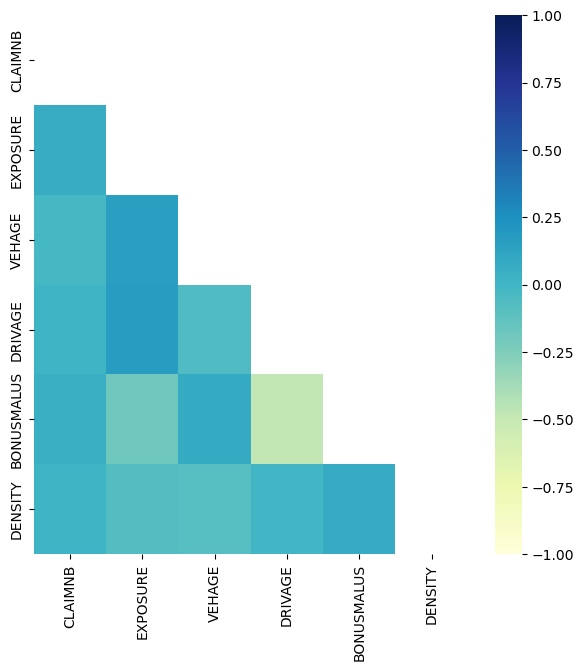

In [300]:


# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_transformed_df, dtype=bool))

# Create a heatmap with the features
plt.figure(figsize=(7, 7))
heatmap = sns.heatmap(corr_transformed_df, mask=mask, cmap="YlGnBu", annot=True, vmin=-1, vmax=1)

In [339]:
insurance_policy_claims_df.describe().sort("SUMMARY").show()

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"SUMMARY"  |"IDPOL"  |"CLAIMNB"           |"EXPOSURE"          |"AREA"  |"VEHPOWER"  |"VEHAGE"           |"DRIVAGE"           |"BONUSMALUS"        |"VEHBRAND"  |"VEHGAS"   |"DENSITY"          |"REGION"  |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|count      |678013   |678013.0            |678013.0            |678013  |678013      |678013.0           |678013.0            |678013.0            |678013      |678013     |678013.0           |678013    |
|max        |99999    |16.0                |2.01                |'F'     |V9          |100.0              |100.0               |230.0               |'B6'        |'Regular'  |27

### Grouping and transforming the features

In [340]:
insurance_policy_claims_df=insurance_policy_claims_df.with_column("Driver_Age_Banded",\
        when(col("DRIVAGE") < 18, lit("DRIVAGE_Under_18")) \
        .when(col("DRIVAGE") <= 21, lit("DRIVAGE_18-21")) \
        .when(col("DRIVAGE") <= 25, lit("DRIVAGE_21-25")) \
        .when(col("DRIVAGE") <= 35, lit("DRIVAGE_25-35")) \
        .when(col("DRIVAGE") <= 45, lit("DRIVAGE_35-45")) \
        .when(col("DRIVAGE") <= 55, lit("DRIVAGE_45-55")) \
        .when(col("DRIVAGE") <= 70, lit("DRIVAGE_55-70")) \
        .otherwise(lit("DRIVAGE_Over_70,")))
import snowflake.snowpark.functions as F

insurance_policy_claims_df=insurance_policy_claims_df.with_column("Vehicle_Age_Banded",\
        when(col("VEHAGE") <= 0, lit("VEHAGE_NewVehicle")) \
        .when(col("VEHAGE") <= 1, lit("VEHAGE_0-1")) \
        .when(col("VEHAGE") <= 4, lit("VEHAGE_1-4")) \
        .when(col("VEHAGE") <= 10, lit("VEHAGE_4-10")) \
        .otherwise(lit("VEHAGE_Over_10,")))
insurance_policy_claims_df.show()


---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"IDPOL"  |"CLAIMNB"  |"EXPOSURE"  |"AREA"  |"VEHPOWER"  |"VEHAGE"  |"DRIVAGE"  |"BONUSMALUS"  |"VEHBRAND"  |"VEHGAS"   |"DENSITY"  |"REGION"  |"DRIVER_AGE_BANDED"  |"VEHICLE_AGE_BANDED"  |
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|1        |1          |0.1         |'D'     |V5          |0         |55         |50            |'B12'       |'Regular'  |1217       |'R82'     |DRIVAGE_45-55        |VEHAGE_NewVehicle     |
|3        |1          |0.77        |'D'     |V5          |0         |55         |50            |'B12'       |'Regular'  |1217       |'R82'     |DRIVAGE_45-55        |VEHAGE_NewVehicle     |
|5        |1          |0.75        |'B'     |V6   

In [341]:
# Step 1: EDA
vehicle_age_banded_df=insurance_policy_claims_df.groupBy("VEHICLE_AGE_BANDED").agg(sum("ClaimNB").alias("vehicle_age_banded_Claims"),\
    sum("Exposure").alias("vehicle_age_banded_Exposure")) \
    .join(insurance_policy_claims_df.groupBy().agg(sum("EXPOSURE").alias("Total_Exposure"))) 

vehicle_age_banded_df  =vehicle_age_banded_df.with_columns(["Percentage_of_total_exposure", "claims_per_unit_exposure"], [(vehicle_age_banded_df["vehicle_age_banded_Exposure"] / vehicle_age_banded_df["Total_Exposure"])\
                                                 ,  (vehicle_age_banded_df["vehicle_age_banded_Claims"]/ vehicle_age_banded_df["vehicle_age_banded_Exposure"] )])

vehicle_age_banded_df.show()

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"VEHICLE_AGE_BANDED"  |"VEHICLE_AGE_BANDED_CLAIMS"  |"VEHICLE_AGE_BANDED_EXPOSURE"  |"TOTAL_EXPOSURE"    |"PERCENTAGE_OF_TOTAL_EXPOSURE"  |"CLAIMS_PER_UNIT_EXPOSURE"  |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|VEHAGE_NewVehicle     |5205                         |16719.028728946534             |358499.44546298234  |0.04663613553810335             |0.3113219125575345          |
|VEHAGE_1-4            |7370                         |79548.8475761656               |358499.44546298234  |0.22189392084953613             |0.09264747667077702         |
|VEHAGE_0-1            |2931                         |32749.537618833587             |358499.44546298234  |0.09135171067430622             |0.08949744

In [342]:
vehicle_age_banded_pd_df=vehicle_age_banded_df.to_pandas()

# Create a plot with dual y-axes
fig3 = px.bar(vehicle_age_banded_pd_df, x='VEHICLE_AGE_BANDED', y='PERCENTAGE_OF_TOTAL_EXPOSURE', labels={'PERCENTAGE_OF_TOTAL_EXPOSURE': '%age of Total Exposure'}, title='Claim Frequency by Vehicle Age')
fig3.add_scatter(x=vehicle_age_banded_pd_df['VEHICLE_AGE_BANDED'], y=vehicle_age_banded_pd_df['CLAIMS_PER_UNIT_EXPOSURE'], mode='lines', name='Actual Frequency', yaxis='y2')

# Update the layout to include the second y-axis
fig3.update_layout(yaxis2=dict(title='Claim Frequency', overlaying='y', side='right'))

# Show the plot
fig3.show()

In [158]:
insurance_policy_claims_df.show()

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"IDPOL"  |"CLAIMNB"  |"EXPOSURE"  |"AREA"  |"VEHPOWER"  |"VEHAGE"  |"DRIVAGE"  |"BONUSMALUS"  |"VEHBRAND"  |"VEHGAS"   |"DENSITY"  |"REGION"  |"DRIVER_AGE_BANDED"  |"VEHICLE_AGE_BANDED"  |
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|1        |1          |0.1         |'D'     |V5          |0         |55         |50            |'B12'       |'Regular'  |1217       |'R82'     |DRIVAGE_45-55        |VEHAGE_NewVehicle     |
|3        |1          |0.77        |'D'     |V5          |0         |55         |50            |'B12'       |'Regular'  |1217       |'R82'     |DRIVAGE_45-55        |VEHAGE_NewVehicle     |
|5        |1          |0.75        |'B'     |V6   

### Data cleaning

Let's remove extra quotation marks


In [343]:
def fix_values(columnn):
    return upper(regexp_replace(columnn, '\'',''))



for col in ["REGION","VEHGAS","VEHBRAND","AREA"]:
    insurance_policy_claims_df = insurance_policy_claims_df.with_column(col, fix_values(col))

insurance_policy_claims_df.show()

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"IDPOL"  |"CLAIMNB"  |"EXPOSURE"  |"VEHPOWER"  |"VEHAGE"  |"DRIVAGE"  |"BONUSMALUS"  |"DENSITY"  |"DRIVER_AGE_BANDED"  |"VEHICLE_AGE_BANDED"  |"REGION"  |"VEHGAS"  |"VEHBRAND"  |"AREA"  |
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|1        |1          |0.1         |V5          |0         |55         |50            |1217       |DRIVAGE_45-55        |VEHAGE_NewVehicle     |R82       |REGULAR   |B12         |D       |
|3        |1          |0.77        |V5          |0         |55         |50            |1217       |DRIVAGE_45-55        |VEHAGE_NewVehicle     |R82       |REGULAR   |B12         |D       |
|5        |1          |0.75        |V6          |2     

### Feature Transformations
We will illustrate a few of the transformation functions here, but the rest can be found in the [documentation](https://docs.snowflake.com/developer-guide/snowpark-ml/snowpark-ml-modeling).

In [344]:
#Log Transformation using Dataframe API

insurance_policy_claims_df=insurance_policy_claims_df.with_column("Log_Density",\
        log(2.718281828459045, insurance_policy_claims_df["Density"]))

insurance_policy_claims_df=insurance_policy_claims_df.drop("DENSITY")

insurance_policy_claims_df.show()



-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"IDPOL"  |"CLAIMNB"  |"EXPOSURE"  |"VEHPOWER"  |"VEHAGE"  |"DRIVAGE"  |"BONUSMALUS"  |"DRIVER_AGE_BANDED"  |"VEHICLE_AGE_BANDED"  |"REGION"  |"VEHGAS"  |"VEHBRAND"  |"AREA"  |"LOG_DENSITY"       |
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|1        |1          |0.1         |V5          |0         |55         |50            |DRIVAGE_45-55        |VEHAGE_NewVehicle     |R82       |REGULAR   |B12         |D       |7.104144092987527   |
|3        |1          |0.77        |V5          |0         |55         |50            |DRIVAGE_45-55        |VEHAGE_NewVehicle     |R82       |REGULAR   |B12         |D       |7.104144092987527   |
|5        

In [345]:
insurance_policy_claims_df.write.mode("overwrite").save_as_table("TESTING_STUFF.MASTERCLASS_FEAT_ENG.masterclass_claims_for_modeling")




##### Let's use the `OrdinalEncoder` to transform `VEHPOWER` from categorical to numerical values so they are more meaningful.

In [346]:
# Ordinal encoding

input_categorical_columns_oe=["VEHPOWER"]
output_categorical_columns_oe = ["VEHPOWER_OE"]
categories_to_ordinal_encode = {
    "VEHPOWER": np.array(["V15", "V14", "V13", "V12", "V11", "V10", "V9", "V8", "V7", "V6", "V5", "V4"]),
}
snowml_oe = snowml.OrdinalEncoder(input_cols=input_categorical_columns_oe, output_cols=output_categorical_columns_oe, categories=categories_to_ordinal_encode)
ord_encoded_claims_df = snowml_oe.fit(insurance_policy_claims_df).transform(insurance_policy_claims_df)

# Show the encoding
print(snowml_oe._state_pandas)

ord_encoded_claims_df.show()

   _COLUMN_NAME _CATEGORY  _INDEX
0      VEHPOWER       V15       0
1      VEHPOWER       V14       1
2      VEHPOWER       V13       2
3      VEHPOWER       V12       3
4      VEHPOWER       V11       4
5      VEHPOWER       V10       5
6      VEHPOWER        V9       6
7      VEHPOWER        V8       7
8      VEHPOWER        V7       8
9      VEHPOWER        V6       9
10     VEHPOWER        V5      10
11     VEHPOWER        V4      11
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"VEHPOWER_OE"  |"IDPOL"  |"CLAIMNB"  |"EXPOSURE"  |"VEHPOWER"  |"VEHAGE"  |"DRIVAGE"  |"BONUSMALUS"  |"DRIVER_AGE_BANDED"  |"VEHICLE_AGE_BANDED"  |"REGION"  |"VEHGAS"  |"VEHBRAND"  |"AREA"  |"LOG_DENSITY"       |
----------------------------------------------------------------------------------------------------------------------------------

##### Let's use the `OneHotEncoder` to transform the categorical columns to numerical columns.


In [347]:
# One hot encoding

input_categorical_columns_ohe=["VEHPOWER", "DRIVER_AGE_BANDED", "VEHICLE_AGE_BANDED","VEHBRAND","VEHGAS","REGION"]
output_categorical_columns_ohe = ["VEHPOWER_OHE", "DRIVER_AGE_BANDED_OHE", "VEHICLE_AGE_BANDED_OHE","VEHBRAND_OHE","VEHGAS_OHE","REGION_OHE"]

snowml_ohe = snowml.OneHotEncoder(input_cols=input_categorical_columns_ohe,\
     output_cols=output_categorical_columns_ohe)
ohencoded_claims_df = snowml_ohe.fit(ord_encoded_claims_df).transform(ord_encoded_claims_df)

np.array(ohencoded_claims_df.columns)


array(['VEHPOWER_OHE_V10', 'VEHPOWER_OHE_V11', 'VEHPOWER_OHE_V12',
       'VEHPOWER_OHE_V13', 'VEHPOWER_OHE_V14', 'VEHPOWER_OHE_V15',
       'VEHPOWER_OHE_V4', 'VEHPOWER_OHE_V5', 'VEHPOWER_OHE_V6',
       'VEHPOWER_OHE_V7', 'VEHPOWER_OHE_V8', 'VEHPOWER_OHE_V9',
       '"DRIVER_AGE_BANDED_OHE_DRIVAGE_18-21"',
       '"DRIVER_AGE_BANDED_OHE_DRIVAGE_21-25"',
       '"DRIVER_AGE_BANDED_OHE_DRIVAGE_25-35"',
       '"DRIVER_AGE_BANDED_OHE_DRIVAGE_35-45"',
       '"DRIVER_AGE_BANDED_OHE_DRIVAGE_45-55"',
       '"DRIVER_AGE_BANDED_OHE_DRIVAGE_55-70"',
       '"DRIVER_AGE_BANDED_OHE_DRIVAGE_Over_70,"',
       '"VEHICLE_AGE_BANDED_OHE_VEHAGE_0-1"',
       '"VEHICLE_AGE_BANDED_OHE_VEHAGE_1-4"',
       '"VEHICLE_AGE_BANDED_OHE_VEHAGE_4-10"',
       '"VEHICLE_AGE_BANDED_OHE_VEHAGE_NewVehicle"',
       '"VEHICLE_AGE_BANDED_OHE_VEHAGE_Over_10,"', 'VEHBRAND_OHE_B1',
       'VEHBRAND_OHE_B10', 'VEHBRAND_OHE_B11', 'VEHBRAND_OHE_B12',
       'VEHBRAND_OHE_B13', 'VEHBRAND_OHE_B14', 'VEHBRAND_OHE_B2',
    

##### Let's use the `KBIN` to transform the categorical columns to numerical columns.



In [348]:
# kbin
#Let's put this into discrete bins and then encode them as ordinals.
input_categorical_columns_kbin=["BONUSMALUS"]
output_categorical_columns_kbin = ["BONUSMALUS_BINNED"]

snowml_kbins = snowml.KBinsDiscretizer(input_cols=input_categorical_columns_kbin, output_cols=output_categorical_columns_kbin, encode = 'ordinal', n_bins = 10)

kbins_transformed_claims_frequency_df = snowml_kbins.fit(ohencoded_claims_df).transform(ohencoded_claims_df)

#np.array(transformed_claims_df.columns)

kbins_transformed_claims_frequency_df.show()

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

##### Finally, we can also build out a full preprocessing `Pipeline`.

This will be useful for both the ML training & inference steps to have standarized feature transformations.

In [349]:
# Build the pipeline
preprocessing_pipeline = Pipeline(
    steps=[
            (
                "OE",
                snowml.OrdinalEncoder(input_cols=input_categorical_columns_oe, output_cols=output_categorical_columns_oe, categories=categories_to_ordinal_encode,)
            ),
            (
                "OHE",
                snowml.OneHotEncoder(input_cols=input_categorical_columns_ohe,output_cols=output_categorical_columns_ohe)
            ),
            (
                "KBINS",
                snowml.KBinsDiscretizer(input_cols=input_categorical_columns_kbin, output_cols=output_categorical_columns_kbin, encode = 'ordinal', n_bins = 10)
            )

    ]
)



In [350]:
PIPELINE_FILE = 'preprocessing_pipeline.joblib'
joblib.dump(preprocessing_pipeline, PIPELINE_FILE) # We are just pickling it locally first



transformed_df = preprocessing_pipeline.fit(insurance_policy_claims_df).transform(insurance_policy_claims_df)
transformed_df.show()



----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [250]:
# You can also save the pickled object into the stage we created earlier for deployment
session.file.put(PIPELINE_FILE, "@MASTERCLASS_ML_ASSETS", overwrite=True)

[PutResult(source='preprocessing_pipeline.joblib', target='preprocessing_pipeline.joblib.gz', source_size=2076, target_size=1136, source_compression='NONE', target_compression='GZIP', status='UPLOADED', message='')]

### 3. ML Modeling
In this section, we will illustrate how to train an XGBoost model with the claims dataset using the Snowpark ML Model API.

The Snowpark ML Model API currently supports sklearn, xgboost, and lightgbm models.

In [351]:
# Specify the table name where we stored the diamonds dataset
# **nChange this only if you named your table something else in the data ingest notebook **
DEMO_TABLE = 'masterclass_claims_for_modeling' 
claims_frequency_modeling_input_tbl = f"{session.get_current_database()}.{session.get_current_schema()}.{DEMO_TABLE}"
# Load in the data
claims_frequency_modeling_df = session.table(claims_frequency_modeling_input_tbl)
claims_frequency_modeling_df.show()


-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"IDPOL"  |"CLAIMNB"  |"EXPOSURE"  |"VEHPOWER"  |"VEHAGE"  |"DRIVAGE"  |"BONUSMALUS"  |"DRIVER_AGE_BANDED"  |"VEHICLE_AGE_BANDED"  |"REGION"  |"VEHGAS"  |"VEHBRAND"  |"AREA"  |"LOG_DENSITY"       |
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|1        |1          |0.1         |V5          |0         |55         |50            |DRIVAGE_45-55        |VEHAGE_NewVehicle     |R82       |REGULAR   |B12         |D       |7.104144092987527   |
|3        |1          |0.77        |V5          |0         |55         |50            |DRIVAGE_45-55        |VEHAGE_NewVehicle     |R82       |REGULAR   |B12         |D       |7.104144092987527   |
|5        

In [352]:
# Categorize all the features for modeling
CATEGORICAL_COLUMNS = [ "DRIVER_AGE_BANDED", "VEHICLE_AGE_BANDED","VEHBRAND","VEHGAS","REGION"]
CATEGORICAL_COLUMNS_OE = ["VEHPOWER_OE"] # To name the ordinal encoded columns
NUMERICAL_COLUMNS = ["EXPOSURE", "LOG_DENSITY", "BONUSMALUS","VEHAGE","DRIVAGE"]

LABEL_COLUMNS = ['CLAIMNB']
OUTPUT_COLUMNS = ['PREDICTED_CLAIMNB']

In [353]:
# Load the preprocessing pipeline object (locally in this case but you can also load the one saved to stage in the previous notebook as an optional exercise)
PIPELINE_FILE = 'preprocessing_pipeline.joblib'
preprocessing_pipeline = joblib.load(PIPELINE_FILE)



### Build a simple XGBoost Regression model
What's happening here?

* The model.fit() function actually creates a temporary stored procedure in the background. This also means that the model training is a single-node operation. Be sure to use a Snowpark Optimized Warehouse if you need more memory. We are just using an XS Standard Virtual Warehouse here, which we created at the beginning of this quickstart.
* The model.predict() function actualls creates a temporary vectorized UDF in the background, which means the input DataFrame is batched as Pandas DataFrames and inference is parallelized across the batches of data.
You can check the query history once you execute the following cell to check.

In [354]:
# Split the data into train and test sets
claims_frequency_train_df, claims_frequency_test_df = claims_frequency_modeling_df.random_split(weights=[0.9, 0.1], seed=0)

# Run the train and test sets through the Pipeline object we defined earlier
train_df = preprocessing_pipeline.fit(claims_frequency_train_df).transform(claims_frequency_train_df)
test_df = preprocessing_pipeline.transform(claims_frequency_test_df)
train_df.show()


----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [355]:
# Define the XGBRegressor
regressor = XGBRegressor(
    input_cols=NUMERICAL_COLUMNS+CATEGORICAL_COLUMNS_OE,
#    input_cols=filtered_list,
    label_cols=LABEL_COLUMNS,
    output_cols=OUTPUT_COLUMNS

)

# Train
regressor.fit(train_df)

# Predict
result = regressor.predict(test_df)
result.show()
df_selected = result.withColumn('PREDICTED_RESULT',round(result["PREDICTED_CLAIMNB"]))

df_selected.show()

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [257]:
# Just to illustrate, we can also pass in a Pandas DataFrame to Snowpark ML's model.predict()
regressor.predict(test_df[CATEGORICAL_COLUMNS_OE+NUMERICAL_COLUMNS].to_pandas())

,VEHPOWER_OE,EXPOSURE,LOG_DENSITY,BONUSMALUS,VEHAGE,DRIVAGE,PREDICTED_CLAIMNB
0,9.0,0.100000,3.610918,50,2,55,0.023600
1,9.0,0.100000,4.442651,76,8,27,0.043466
2,10.0,0.010000,7.465083,100,0,33,0.379001
3,10.0,0.790000,6.120297,50,0,59,0.114175
4,0.0,0.110000,6.173786,50,0,51,0.046783
...,...,...,...,...,...,...,...
67945,4.0,0.008219,2.890372,50,0,64,-0.003730
67946,8.0,0.005479,5.572154,50,2,48,0.020894
67947,11.0,0.005479,8.586719,80,0,29,-0.002572
67948,4.0,0.005479,8.586719,74,0,49,-0.019897


Let's analyze the results using Snowpark ML's MSE.

In [356]:
from snowflake.ml.modeling.metrics import mean_squared_error

mse = mean_squared_error(df=df_selected, 
                                        y_true_col_names="CLAIMNB", 
                                        y_pred_col_names="PREDICTED_RESULT")

df_selected.select("CLAIMNB", "PREDICTED_RESULT").show()
print(f"Mean squared error: {mse}")

----------------------------------
|"CLAIMNB"  |"PREDICTED_RESULT"  |
----------------------------------
|1          |0.0                 |
|1          |0.0                 |
|1          |0.0                 |
|1          |0.0                 |
|1          |0.0                 |
|1          |0.0                 |
|1          |0.0                 |
|1          |0.0                 |
|1          |0.0                 |
|1          |0.0                 |
----------------------------------

Mean squared error: 0.06185430463576159


### Now, let's use Snowpark ML's Distributed GridSearchCV() function to find optimal model parameters
We will increase the warehouse size to scale up our hyperparameter tuning to take advantage of parallelized model training to accelerate this search.

In [357]:
session.sql("ALTER WAREHOUSE DEMO_WH SET WAREHOUSE_SIZE=LARGE;").collect()

[Row(status='Statement executed successfully.')]

In [260]:
grid_search = GridSearchCV(
    estimator=XGBRegressor(),
    param_grid={
        "n_estimators":[100, 200, 300, 400, 500],
        "learning_rate":[0.1, 0.2, 0.3, 0.4, 0.5],
    },
    n_jobs = -1,
    scoring="neg_mean_absolute_percentage_error",
    input_cols=CATEGORICAL_COLUMNS_OE+NUMERICAL_COLUMNS,
    label_cols=LABEL_COLUMNS,
    output_cols=OUTPUT_COLUMNS
)

# Train
grid_search.fit(train_df)

Package 'fastparquet' is not installed in the local environment. Your UDF might not work when the package is installed on the server but not on your local environment.
The version of package 'pyarrow' in the local environment is 14.0.2, which does not fit the criteria for the requirement 'pyarrow<14'. Your UDF might not work when the package version is different between the server and your local environment.


In [261]:
session.sql("ALTER WAREHOUSE DEMO_WH SET WAREHOUSE_SIZE=XSMALL;").collect()

[Row(status='Statement executed successfully.')]

We see that the best estimator has the following parameters: n_estimators=100 & learning_rate=0.1.

We can use to_sklearn() in order to get the actual xgboost model object, which gives us access to all its attributes.

In [262]:
grid_search.to_sklearn().best_estimator_

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=3, num_parallel_tree=None, predictor=None,
             random_state=None, ...)

We can also analyze the grid search results.

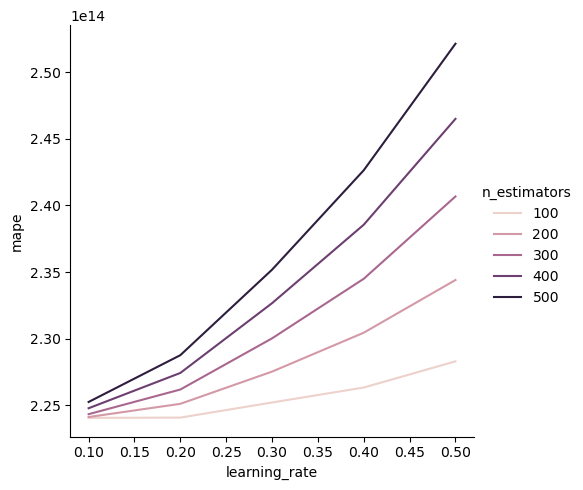

In [358]:
# Analyze grid search results
gs_results = grid_search.to_sklearn().cv_results_
n_estimators_val = []
learning_rate_val = []
for param_dict in gs_results["params"]:
    n_estimators_val.append(param_dict["n_estimators"])
    learning_rate_val.append(param_dict["learning_rate"])
mape_val = gs_results["mean_test_score"]*-1

gs_results_df = pd.DataFrame(data={
    "n_estimators":n_estimators_val,
    "learning_rate":learning_rate_val,
    "mape":mape_val})

sns.relplot(data=gs_results_df, x="learning_rate", y="mape", hue="n_estimators", kind="line")

plt.show()

This is consistent with the learning_rate=0.1 and n_estimator=100 chosen as the best estimator with the lowest MAPE.

Now, let's predict and analyze the results from using the best estimator.

In [359]:
# Predict
result = grid_search.predict(test_df)

# Analyze results
mse = mean_squared_error(df=result, 
                                        y_true_col_names="CLAIMNB", 
                                        y_pred_col_names="PREDICTED_CLAIMNB")

result.select("CLAIMNB", "PREDICTED_CLAIMNB").show()
print(f"Mean squared error: {mse}")

------------------------------------
|"CLAIMNB"  |"PREDICTED_CLAIMNB"   |
------------------------------------
|1          |0.02156894840300083   |
|1          |0.0342085100710392    |
|1          |0.5128198862075806    |
|1          |0.1269509494304657    |
|1          |0.09609178453683852   |
|1          |0.032330919057130814  |
|1          |0.07963481545448303   |
|1          |0.034304648637771606  |
|1          |0.2058368474245071    |
|1          |0.15070107579231262   |
------------------------------------

Mean squared error: 0.05687870741588792


In [ ]:
####### MODELING ENDS

In [207]:
train_df.schema


StructType([StructField('BONUSMALUS_BINNED', LongType(), nullable=True), StructField('VEHPOWER_OHE_V10', DoubleType(), nullable=True), StructField('VEHPOWER_OHE_V11', DoubleType(), nullable=True), StructField('VEHPOWER_OHE_V12', DoubleType(), nullable=True), StructField('VEHPOWER_OHE_V13', DoubleType(), nullable=True), StructField('VEHPOWER_OHE_V14', DoubleType(), nullable=True), StructField('VEHPOWER_OHE_V15', DoubleType(), nullable=True), StructField('VEHPOWER_OHE_V4', DoubleType(), nullable=True), StructField('VEHPOWER_OHE_V5', DoubleType(), nullable=True), StructField('VEHPOWER_OHE_V6', DoubleType(), nullable=True), StructField('VEHPOWER_OHE_V7', DoubleType(), nullable=True), StructField('VEHPOWER_OHE_V8', DoubleType(), nullable=True), StructField('VEHPOWER_OHE_V9', DoubleType(), nullable=True), StructField('"DRIVER_AGE_BANDED_OHE_DRIVAGE_18-21"', DoubleType(), nullable=True), StructField('"DRIVER_AGE_BANDED_OHE_DRIVAGE_21-25"', DoubleType(), nullable=True), StructField('"DRIVER_AG

In [ ]:
session.close()

In [ ]:
####### FEATURE STORE BEGINS

In [93]:
fs = FeatureStore(
    session=session,
    database="TESTING_STUFF",
#    name="CLAIM_FREQUENCY_FEATURE_STORE",
    name="MASTERCLASS_FEAT_ENG",
    default_warehouse="DEMO_WH",
    creation_mode=CreationMode.CREATE_IF_NOT_EXIST,
)


entity = Entity(name="CLAIM_FREQUENCY_FEATURES_5", join_keys=["IDPOL"])

fs.register_entity(entity)

fs.list_entities().show()

claim_frequency_features_view_5 = FeatureView(
name = "CLAIM_FREQUENCY_FEATURES_VIEW_5",
entities = [entity],
feature_df = ord_encoded_claims_df,
desc = "features for modeling claims frequency"
)

claim_frequency_view_registered = fs.register_feature_view(
feature_view = claim_frequency_features_view_5,
version = "V5",
block = True
)



-----------------------------------------------------
|"NAME"                      |"JOIN_KEYS"  |"DESC"  |
-----------------------------------------------------
|CLAIM_FREQUENCY_FEATURES_2  |IDPOL        |        |
|CLAIM_FREQUENCY_FEATURES_3  |IDPOL        |        |
|CLAIM_FREQUENCY_FEATURES_4  |IDPOL        |        |
|CLAIM_FREQUENCY_FEATURES_5  |IDPOL        |        |
-----------------------------------------------------



In [94]:
### Use Feature Store
#original_claims_df = session.table(f"testing_stuff.masterclass_feat_eng.masterclass_motor_insurance_policy_claims")
original_claims_df = insurance_policy_claims_df

#original_claims_df = original_claims_df.select("IDPOL")


original_claims_df.show(5)




------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"IDPOL"  |"CLAIMNB"  |"EXPOSURE"  |"AREA"  |"VEHPOWER"  |"VEHAGE"  |"DRIVAGE"  |"BONUSMALUS"  |"VEHBRAND"  |"VEHGAS"   |"REGION"  |"LOG_DENSITY"       |"DRIVER_AGE_BANDED"  |"VEHICLE_AGE_BANDED"  |
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|1        |1          |0.1         |'D'     |V5          |0         |55         |50            |'B12'       |'Regular'  |'R82'     |7.104144092987527   |DRIVAGE_45-55        |VEHAGE_NewVehicle     |
|3        |1          |0.77        |'D'     |V5          |0         |55         |50            |'B12'       |'Regular'  |'R82'     |7.104144092987527   |DRIVAGE_45-55        |VEHAGE_NewVehicle     |
|5   

In [ ]:
training_data = fs.generate_dataset(
    spine_df=original_claims_df, 
    features=[claim_frequency_view_registered], 
    materialized_table="CLAIMS_FREQUENCY_TRAINING_DATA_TABLE",  
    spine_label_cols=["CLAIMNB"],
    save_mode="merge",
    exclude_columns=['IDPOL']
)

In [91]:
kbins_transformed_claims_frequency_df.show()

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
###### FEATURE STORE ENDS

In [ ]:

# split out the validation set
train_x, val_x, train_y, val_y,train_evy,val_evy = train_test_split(
    insurance_policy_claims_pd_df.drop(labels = ['CLAIMNB','EXPOSURE'],axis = 1),
    insurance_policy_claims_pd_df['CLAIMNB'],
    insurance_policy_claims_pd_df['EXPOSURE'],
    test_size = 0.15,
    random_state = 0,
    shuffle = True
)
train_x.head()

,IDPOL,AREA,VEHPOWER,VEHAGE,DRIVAGE,BONUSMALUS,VEHBRAND,VEHGAS,DENSITY,REGION,LOG_DENSITY,DRIVER_AGE_BANDED
569140,4160318,'B',4,13,40,61,'B2','Diesel',60,'R24',4.094345,35-45
316674,2228501,'E',4,7,34,76,'B2','Regular',3862,'R31',8.258940,25-35
426416,3141391,'C',4,13,36,50,'B6','Regular',263,'R82',5.572154,35-45
466729,3212853,'A',6,22,36,54,'B1','Regular',46,'R24',3.828641,35-45
457096,3190851,'A',7,9,70,50,'B1','Regular',3,'R24',1.098612,55-70


In [ ]:
val_x.head()

,IDPOL,AREA,VEHPOWER,VEHAGE,DRIVAGE,BONUSMALUS,VEHBRAND,VEHGAS,DENSITY,REGION,LOG_DENSITY,DRIVER_AGE_BANDED
458475,3194022,'A',7,18,55,50,'B2','Diesel',43,'R24',3.761200,45-55
305693,2217503,'D',4,16,40,55,'B1','Regular',1765,'R31',7.475906,35-45
581980,4173158,'A',4,13,72,50,'B2','Regular',49,'R24',3.891820,"Over_70,"
382393,3044732,'D',10,0,39,50,'B12','Regular',528,'R93',6.269096,35-45
304625,2216435,'C',7,10,57,50,'B11','Diesel',113,'R91',4.727388,55-70


In [ ]:
val_y.head()

458475    0
305693    0
581980    0
382393    0
304625    0
Name: CLAIMNB, dtype: int8

In [ ]:

# %%timeit
# insurance_policy_claims_pd_df=insurance_policy_claims_df.to_pandas()
# insurance_policy_claims_agg_pd_df = (
#     insurance_policy_claims_pd_df
#     .groupby('AREA')
#     .agg({'EXPOSURE': 'sum', 'CLAIMNB': 'sum'})
#     .reset_index()
#     .assign(
#         PERCENTAGE_OF_TOTAL_EXPOSURE=lambda x: (x['EXPOSURE'] / x['EXPOSURE'].sum()) ,
#         CLAIMS_PER_UNIT_EXPOSURE=lambda x: (x['CLAIMNB'] / x['EXPOSURE']) 
#     )
# )
# insurance_policy_claims_agg_pd_df.head()
#EDA1 with pandas 